In [1]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  
import copy

import tools.Sample_Tools as smpl
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)


import matplotlib.pyplot as plt
import seaborn as sns

# from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

# from sklearn.decomposition import FactorAnalysis
# from factor_analyzer import FactorAnalyzer
# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

# import inspect
import warnings
from sklearn.model_selection import train_test_split

from catboost import CatBoost
from catboost import CatBoostRanker, Pool, MetricVisualizer,CatBoostRegressor,CatBoostClassifier


In [2]:
file_names = ['base10','alpha42', '191_alpha010', 'mom_effect_coin','turn_Amihud_Pvc_2023','macd']

# 'alpha54','alpha60','alpha77','191_alpha004','191_alpha021', '191_alpha070', '191_alpha095', '191_alpha115', 
#  '191_alpha124', '191_alpha126', '191_alpha129', '191_alpha132', '191_alpha143', '191_alpha144', 
#   '191_alpha146', '191_alpha150', '191_alpha153', '191_alpha160', '191_alpha161', '191_alpha173', '191_alpha187',

temp = []
for file in file_names:
    print(file)
    temp.append(load_cache(file+'_train',cache_type=CACHE_TYPE.FACTOR)
)

data_all = pd.concat(temp,axis=1).sort_index()#.loc[(slice('2017-01-11','2020-12-24'),codes),:]

# excluded = data_all.columns.difference(['191_alpha149'],sort=False) 

base10
alpha42
191_alpha010
mom_effect_coin
turn_Amihud_Pvc_2023
macd


In [3]:
data_slice = data_all.loc[(slice('2018-01-11','2020-12-24'),slice(None))]

In [4]:
codes = data_slice.index.get_level_values(1).unique()
dates = data_slice.index.get_level_values(0).unique()
data_replenish = load_cache_adv('all_train_qfq',
                                dates.min().strftime('%Y-%m-%d'),
                                dates.max().strftime('%Y-%m-%d'),
                                cache_type=CACHE_TYPE.STOCK)

data_replenish = data_replenish.loc[(slice(None),data_replenish.index.get_level_values(1).unique().intersection(codes)),]

ret = smpl.get_forward_return(data_replenish,'close')
ret.name = 'target'
ret[np.abs(ret)>0.15]=np.nan

## 未来X日总收益
ret = np.exp(excute_for_multidates(np.log(ret+1).sort_index(level=0,ascending=False),lambda x:x.rolling(20).sum(),level='code'))-1
ret = ret.sort_index(level=0,ascending=True)

industy = data_replenish['industry']
industy.name = 'industy'

cap_log = np.log(data_replenish['market_value'])
cap_log.name = 'cap_log'


data = pd.concat([data_slice,industy,cap_log,ret],axis=1).sort_index().dropna()

# data_invert = data[data.columns.difference(['191_alpha004','industy','cap_log'])]*-1
# data_invert = pd.concat([data_invert,data[['191_alpha004','industy','cap_log']]],axis=1)
# data_augmentation = pd.concat([data, data_invert],axis=0).sort_index()
data_augmentation =data

In [5]:
data = data_augmentation
data['industy'] = data['industy'].astype('string')
# data['191_alpha004'] = data['191_alpha004'].astype('int')
data['MACD_CROSS'] = data['MACD_CROSS'].astype('int')
data['DEVIATE'] = data['DEVIATE'].astype('int')
data['SWING_BAND'] = data['SWING_BAND'].astype('int')


train_data = data[data.columns.difference(['target'])]
train_target = data[['target']]

X_train,X_test, y_train, y_test =train_test_split(train_data,train_target,test_size=.1, shuffle=False)

# X_train,X_keep, y_train, y_keep =train_test_split(train_data,train_target,test_size=.1, shuffle=False)
# X_train,X_test, y_train, y_test =train_test_split(X_train,y_train,test_size=.1, shuffle=True)

# X_train=X_train.sort_index()
# X_test=X_test.sort_index()
# y_train=y_train.sort_index()
# y_test=y_test.sort_index()


# y_train_group = y_train.index.get_level_values(0).strftime('%Y-%m-%d').tolist()
# y_test_group = y_test.index.get_level_values(0).strftime('%Y-%m-%d').tolist()

# X_train=X_train.sort_index(level='code')
# X_test=X_test.sort_index(level='code')
# y_train=y_train.sort_index(level='code')
# y_test=y_test.sort_index(level='code')
# y_train_group = y_train.index.get_level_values(1).tolist()
# y_test_group = y_test.index.get_level_values(1).tolist()

In [81]:
# y_train.groupby(level=0).count()
# X_train.nunique()


In [6]:
categorical_features_names = ['industy','MACD_CROSS','DEVIATE','SWING_BAND'] #'191_alpha004', 
# categorical_features_names = ['industy']
train_p = Pool(
    data=X_train,
    label=np.sign(y_train['target']).map({-1:0,1:1,0:0}),
    # label=y_train,
    # group_id=y_train_group,
    cat_features=categorical_features_names
)

test_p = Pool(
    data=X_test,
    label=np.sign(y_test['target']).map({-1:0,1:1,0:0}),
    # label=y_test,
    # group_id=y_test_group,
    cat_features=categorical_features_names
)

In [7]:
default_parameters = {
    'learning_rate': .05,
    'iterations': 100,
    'custom_metric': None,
    'verbose': False,
    'random_seed': 0,
    'use_best_model':True,
    'early_stopping_rounds': 10,
}



def fit_model(model_class ,loss_function, train_pool, test_pool, additional_params=None, verbose=False):
    parameters = copy.deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    if type(loss_function) == str:
        parameters['train_dir'] = loss_function.replace(':','_').replace('=','_')
    else:
        parameters['train_dir'] = loss_function.__class__.__name__
        
    parameters['verbose'] = verbose
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    
    # print(parameters)
    if model_class == CatBoost:
        mod = model_class(parameters)
    else:
        mod = model_class(**parameters)
        
    mod.fit(train_pool, eval_set=test_pool, plot=True)
    
    return mod


In [210]:
# parameters = {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']}
# parameters = {'custom_metric': ['PFound',  'AverageGain:top=10'],}
# parameters = {'custom_metric': ['NDCG',  'AverageGain:top=100'],}
# parameters={'learning_rate': .1,'custom_metric': ['NDCG:type=ranking',  'AverageGain:top=1000'],'eval_metric':'AUC:type=Ranking','one_hot_max_size': X_train['industy'].nunique()}
# parameters={'learning_rate': .1,'custom_metric': ['NDCG', 'AverageGain:top=1000'],'one_hot_max_size': 0}

# parameters={'learning_rate': .3,'custom_metric': ['R2'],'one_hot_max_size': 0,'early_stopping_rounds':None,'iterations': 200,'use_best_model':False}

# model = fit_model(CatBoostRegressor, 'RMSE', train_p, test_p, parameters, verbose=False)




In [8]:
parameters={'learning_rate': .3,'custom_metric': ['Precision','AUC'],'one_hot_max_size': 0,'early_stopping_rounds':None,'iterations': 200, 'use_best_model':False}
model = fit_model(CatBoostClassifier, 'CrossEntropy', train_p, test_p, parameters, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
y_pred = model.predict(data=X_train,prediction_type='Class')   #'Class',RawFormulaVal,Probability, LogProbability
y_data = np.sign(y_train['target']).map({-1:0,1:1,0:0}).values.squeeze()
print((y_pred==y_data).sum()/len(y_pred))

y_pred = model.predict(data=X_test,prediction_type='Class')   #Class,RawFormulaVal,Probability, LogProbability
y_data = np.sign(y_test['target']).map({-1:0,1:1,0:0}).values.squeeze()
print((y_pred==y_data).sum()/len(y_pred))

# y_pred = model.predict(data=X_keep,prediction_type='Class')   #Class,RawFormulaVal,Probability, LogProbability
# y_data = np.sign(y_keep['target']).map({-1:0,1:1,0:0}).values.squeeze()
# print((y_pred==y_data).sum()/len(y_pred))

0.7286844387036
0.5692531005735499


In [125]:
# 未来1日
# 0.5769210621568706
# 0.5314988727614745

# 未来5日
# 0.6152764985650114
# 0.5469538320324656


# 未来10日
# 0.6590015072246937
# 0.5560097121538222

# 未来20日
# 0.7043004187617854
# 0.5630177595870658

# 未来20日 无增广  留10%回测试
# 18-20 !!!!!          2018                 2019                2020
# 0.7258981806405945   0.8321801284818323   0.8175722727363164  0.7891402019891709
# 0.5689488412880596    0.6683329524680073  0.6072977597389678  0.574014115250291

# 18-20 加macd cros_catego dev_numbr    cros_catego dev_catego    abs(reciprocal(macd))
# 0.7297075584302813                    0.7269750087048975        0.7269750087048975
# 0.5695549566047226                    0.5721599628593168        0.5721599628593168

# 18-20 加SWING_BAND
# 0.7313582649240632
# 0.5693163792992275




# 2020 dategroup       # 2020 codegroup
# 0.7740708477926509   0.7834912152698478
# 0.5848733993015134   0.5680296856810244


# 未来20日 无增广 乱序训练， 留10%回测试
# 18-20               2019                2020
# 0.7220633200895725  0.816449446592355   0.7874404054785414
# 0.571495815225101   0.6122518005650391  0.5769608556461001
 






In [39]:
# y_test.iloc[200:500].values.squeeze()
y_pred = model.predict(data=X_train,prediction_type='RawFormulaVal')   #'Class',RawFormulaVal,Probability, LogProbability
y_data = np.sign(y_train).values.squeeze()
print((np.sign(y_pred)==y_data).sum()/len(y_pred))

y_pred = model.predict(data=X_test,prediction_type='RawFormulaVal')   #Class,RawFormulaVal,Probability, LogProbability
y_data = np.sign(y_test).values.squeeze()
print((np.sign(y_pred)==y_data).sum()/len(y_pred))

0.5346805168697931
0.5053659428052885


In [175]:
# plt.figure(figsize=(1120/72,420/72))
# plt.scatter(range(len(y_pred)), np.sign(y_pred),linewidths=4)
# plt.scatter(range(len(y_pred)), np.sign(y_test.iloc[700:900].values.squeeze()))
np.unique(y_pred,return_counts=True)

(array([0, 1], dtype=int64), array([412175, 225071], dtype=int64))

In [11]:
data_slice.corr()

,beta,alpha,residual,momentum,sizelg,bp,earnings_yield,liquidity,resvol,sizenl,...,amihud_adv,amihud_negative,amihud_cv,obv,pvc,pvc_optimize,MACD,MACD_CROSS,DEVIATE,SWING_BAND
beta,1.000000e+00,-0.004728,0.001383,-0.028440,-2.137239e-01,0.014750,-0.085913,4.510133e-01,-1.018265e-17,-0.060617,...,-0.011390,-0.021792,0.004795,0.013325,0.110224,0.025373,0.004053,0.001417,0.012563,-0.004832
alpha,-4.728397e-03,1.000000,0.078294,0.330985,2.024318e-01,0.017781,0.045870,2.548906e-01,3.649624e-01,-0.101963,...,-0.092791,-0.207527,-0.023968,0.074592,0.091651,0.031530,0.068544,0.002538,-0.130223,0.058651
residual,1.382784e-03,0.078294,1.000000,-0.028233,6.476725e-04,0.001576,0.048991,-2.104503e-02,-1.353194e-02,-0.003880,...,-0.000639,0.022534,-0.056638,0.420488,0.088843,-0.011331,0.081627,0.183495,-0.126525,0.011189
momentum,-2.843996e-02,0.330985,-0.028233,1.000000,1.904629e-01,0.008939,-0.037329,1.168648e-01,1.266549e-01,-0.062436,...,-0.063097,-0.181128,0.029081,0.001780,-0.012974,-0.020135,-0.079840,0.010924,0.011258,-0.127688
sizelg,-2.137239e-01,0.202432,0.000648,0.190463,1.000000e+00,0.004256,0.092936,1.277135e-17,1.221907e-17,-0.267122,...,-0.142339,-0.421017,0.047909,0.033137,-0.066985,-0.025585,0.005795,-0.000300,-0.021895,0.001462
bp,1.474986e-02,0.017781,0.001576,0.008939,4.256204e-03,1.000000,-0.005585,5.348367e-03,-2.801052e-03,0.011143,...,0.003232,0.010246,0.000588,0.001476,-0.001695,-0.002497,0.001632,-0.000074,-0.003811,0.000184
earnings_yield,-8.591273e-02,0.045870,0.048991,-0.037329,9.293611e-02,-0.005585,1.000000,-9.110724e-02,-1.086921e-01,-0.029924,...,-0.043062,-0.073215,-0.001137,0.039260,0.093489,0.080060,0.104109,-0.001299,-0.095027,0.165511
liquidity,4.510133e-01,0.254891,-0.021045,0.116865,1.277135e-17,0.005348,-0.091107,1.000000e+00,4.106163e-01,-0.023936,...,-0.106627,-0.329210,-0.004725,0.021635,0.125167,0.013949,-0.010255,-0.005964,0.004602,-0.022346
resvol,-1.018265e-17,0.364962,-0.013532,0.126655,1.221907e-17,-0.002801,-0.108692,4.106163e-01,1.000000e+00,-0.021971,...,-0.012815,-0.110667,-0.048982,0.023819,0.030602,-0.042339,-0.028659,-0.001294,0.036109,-0.053617
sizenl,-6.061672e-02,-0.101963,-0.003880,-0.062436,-2.671223e-01,0.011143,-0.029924,-2.393587e-02,-2.197134e-02,1.000000,...,0.091741,0.273024,-0.006229,-0.008063,-0.011049,0.001168,0.000196,-0.000822,0.002706,-0.000383


In [333]:
# model.get_feature_importance(train_p)
# feature_importances = model.get_feature_importance(train_p)
# for score, name in sorted(zip(feature_importances, X_train.columns), reverse=True):
#     print('{}: {}'.format(name, score))
######
# widget = MetricVisualizer(['model_depth_5', 'model_depth_8']) #事后对比，model_depth_5是‘train_dir’
# widget.start()
####
# model.save_model('catboost_model.dump')
# model = CatBoostClassifier()
# model.load_model('catboost_model.dump');

########Batch_training
# model1 = CatBoostRegressor(**params)
# batch1 = Pool(train_data1, label=train_labels1)
# model1.fit(X=batch1)
# # continue training with different portion of data
# model2 = CatBoostRegressor(**params)
# batch2 = Pool(train_data2, label=train_labels2)
# batch2.set_baseline(model1.predict(batch2))
# model2.fit(X=batch2)
# # build resulting model
# model = sum_models([model1, model2])



In [ ]:
# class LossObjective(object):
#     # L​(θ;X,y)=1− 1/N​*∑​max(μi​−yi​,0)**2
#     def calc_ders_range(self, approxes, targets, weights):
#         result = []
#         d = approxes*(-2) - targets*(-2)
#         for index in range(len(targets)):
#             if approxes[index]-targets[index] >0:
#                 der1 = d[index]
#                 der2 = -2
#             else:
#                 der1 = 1
#                 der2 = 0

#             if weights is not None:
#                 der1 *= weights[index]
#                 der2 *= weights[index]

#             result.append((der1, der2))
#         return result
    

# parameters={'learning_rate': .5,'eval_metric': 'RMSE','custom_metric': ['R2'],'one_hot_max_size': 0,'early_stopping_rounds':None,'iterations': 120,'use_best_model':False}
# model = fit_model(CatBoostRegressor, LossObjective(), train_p, test_p, parameters, verbose=False)

<BarContainer object of 32 artists>

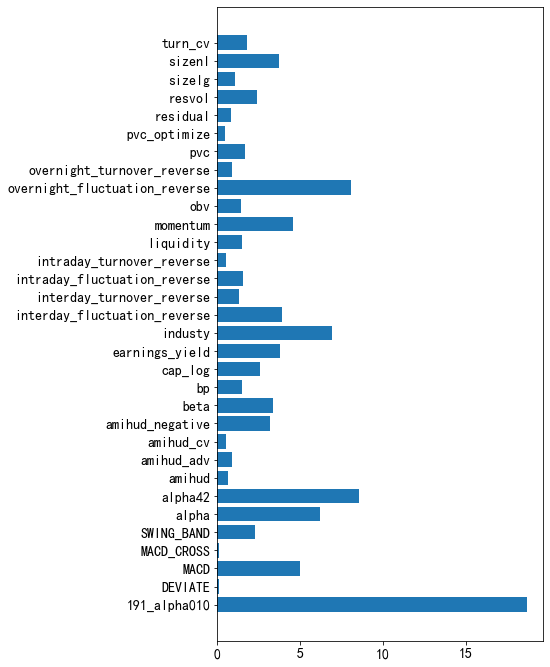

In [10]:
plt.figure(figsize=(420/72,840/72))
plt.barh(X_train.columns,model.feature_importances_)